In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_data.data.shape

loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [2]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [4]:
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)}] Loss: {loss.item()}")

In [5]:
def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(f"\nTest set: Average loss: {test_loss}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset)})\n")

In [6]:
for epoch in range(1, 21):
    train(epoch)
    test()

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000] Loss: 2.3090527057647705
Train Epoch: 1 [1000/60000] Loss: 2.2931160926818848
Train Epoch: 1 [2000/60000] Loss: 2.309715986251831
Train Epoch: 1 [3000/60000] Loss: 2.3121042251586914
Train Epoch: 1 [4000/60000] Loss: 2.3011107444763184
Train Epoch: 1 [5000/60000] Loss: 2.3152594566345215
Train Epoch: 1 [6000/60000] Loss: 2.299689769744873
Train Epoch: 1 [7000/60000] Loss: 2.301908493041992
Train Epoch: 1 [8000/60000] Loss: 2.2894504070281982
Train Epoch: 1 [9000/60000] Loss: 2.308558702468872
Train Epoch: 1 [10000/60000] Loss: 2.315563201904297
Train Epoch: 1 [11000/60000] Loss: 2.305633306503296
Train Epoch: 1 [12000/60000] Loss: 2.3015384674072266
Train Epoch: 1 [13000/60000] Loss: 2.294410467147827
Train Epoch: 1 [14000/60000] Loss: 2.3060483932495117
Train Epoch: 1 [15000/60000] Loss: 2.285630702972412
Train Epoch: 1 [16000/60000] Loss: 2.307483434677124
Train Epoch: 1 [17000/60000] Loss: 2.288752794265747
Train Epoch: 1 [18000/60000] Loss: 2.30139780044555

Prédiction pour l'image 1: 6
Valeur réelle: 6
Prédiction pour l'image 2: 0
Valeur réelle: 0
Prédiction pour l'image 3: 5
Valeur réelle: 5
Prédiction pour l'image 4: 4
Valeur réelle: 4
Prédiction pour l'image 5: 9
Valeur réelle: 9
Prédiction pour l'image 6: 9
Valeur réelle: 9
Prédiction pour l'image 7: 2
Valeur réelle: 2
Prédiction pour l'image 8: 1
Valeur réelle: 1
Prédiction pour l'image 9: 9
Valeur réelle: 9
Prédiction pour l'image 10: 4
Valeur réelle: 4


Note: 10/10


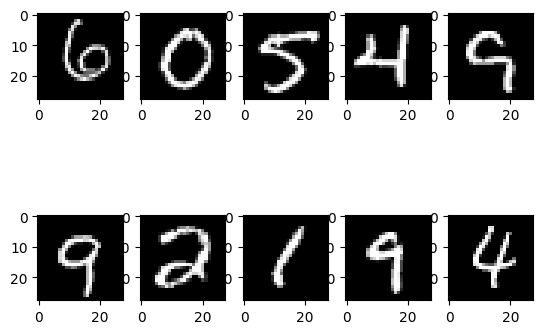

In [8]:
leModel = Net()

leModel.load_state_dict(torch.load("mnist_cnn.pt"))

leModel.eval()

for i in range(10):

    data, target = test_data[i+100]
    data = data.unsqueeze(0).to(device)

    output = leModel(data)

    prediction = output.argmax(dim=1, keepdim=True).item()

    print(f"Prédiction pour l'image {i+1}: {prediction}")

    image = data.squeeze(0).squeeze(0).cpu().numpy()
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap="rainbow")

    print(f"Valeur réelle: {target}")

good_predictions = 0

for i in range(10):
    data, target = test_data[i+100]
    data = data.unsqueeze(0).to(device)
    output = leModel(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    image = data.squeeze(0).squeeze(0).cpu().numpy()
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap="gray")
    if prediction == target:
        good_predictions += 1

print("")
print("")
print(f"Note: {good_predictions}/10")